In [19]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import os

In [50]:
folder = "results"
files = os.listdir(folder)

df = pd.DataFrame()
for file in files:
    chunk = file.split("chunk-")[1].split("_")[0]
    chunk = int(chunk)
    search = file.split("search-")[1].split("_")[0]
    lim = file.split("lim-")[1].split("_")[0]
    expand = file.split("expand-")[1].split(".")[0]

    temp_df = pd.read_csv(os.path.join(folder, file))
    temp_df["chunk"] = chunk
    temp_df["search"] = search
    temp_df["lim"] = int(lim)
    temp_df["expand"] = int(expand)
    df = pd.concat([df, temp_df])
    df = df.reset_index(drop=True)


df_summary = df.groupby(["search", "lim", "expand"]).sum()
df_summary = df_summary.reset_index()

df_summary["recall"] = (df_summary["n_retrieved_rules"] / df_summary["n_target_rules"]).round(2)
df_summary["recall/context"] = (df_summary["recall"] / df_summary["len_context"]).round(8)


column_orders = ["chunk", "search", "expand", "lim", "len_context", "recall", "recall/context"]
df_summary[column_orders]

,chunk,search,expand,lim,len_context,recall,recall/context
0,390000,semantic,0,1,271641,0.46,1.690000e-06
1,390000,semantic,1,1,679813,0.50,7.400000e-07
2,390000,semantic,2,1,1082800,0.52,4.800000e-07
3,390000,semantic,0,2,542733,0.55,1.010000e-06
4,390000,semantic,1,2,1195600,0.59,4.900000e-07
5,390000,semantic,2,2,1833439,0.62,3.400000e-07
6,390000,semantic,0,3,802144,0.60,7.500000e-07
7,390000,semantic,1,3,1668870,0.64,3.800000e-07
8,390000,semantic,2,3,2504310,0.66,2.600000e-07
9,390000,semantic,0,4,1052255,0.63,6.000000e-07


In [49]:
# Create two subplots vertically stacked
fig = make_subplots(rows=3, cols=1, 
                    subplot_titles=(
                        "Recall vs Limit",
                        "Context Length vs Limit",
                        "Recall / Context Length vs Limit"
                    ))

for i in range(3):  # Assuming 3 expand values (0, 1, 2)
    # Add the recall plot
    trace1 = px.line(df_summary, x="lim", y="recall", color="expand", markers=True).data[i]
    fig.add_trace(trace1, row=1, col=1)
    
    # Add the context length plot
    trace2 = px.line(df_summary, x="lim", y="len_context", color="expand", markers=True).data[i]
    trace2.showlegend = False  # Hide duplicate legends
    fig.add_trace(trace2, row=2, col=1)

    # Add the recall per context plot
    trace3 = px.line(df_summary, x="lim", y="recall/context", color="expand", markers=True).data[i]
    trace3.showlegend = False  # Hide duplicate legends
    fig.add_trace(trace3, row=3, col=1)

# Update layout for dark theme and other customizations
fig.update_layout(
    template="plotly_dark",
    height=800,
    legend_title="Expand Setting",
    xaxis_title="Limit",
    xaxis2_title="Limit",
    xaxis3_title="Limit",
    yaxis_title="Recall",
    yaxis2_title="Context Length",
    yaxis3_title="Recall / Context Length"
)
# Set y-axes to start at 0
fig.update_yaxes(range=[0, None], row=1, col=1)  # First plot
fig.update_yaxes(range=[0, None], row=2, col=1)  # Second plot
fig.update_yaxes(range=[0, None], row=3, col=1)  # Third plot
fig.show()


In [71]:
px.scatter(df_summary, x="len_context", y="recall", color="expand", size="lim")


# Fancy analysis

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict
import seaborn as sns

@dataclass
class OptimizationResult:
    expand: int
    limit: int
    score: float
    recall: float
    context_length: int
    
def calculate_cost_function(row, 
                          alpha: float = 0.7,
                          token_cost_weight: float = 0.3,
                          min_recall: float = 0.45,
                          price_per_token: float = 0.0001) -> float:
    """
    Calculate optimization score for a given configuration.
    """
    if row['recall'] < min_recall:
        return float('-inf')
    
    max_context = 4_000_000
    normalized_context = row['len_context'] / max_context
    token_cost = row['len_context'] * price_per_token
    normalized_cost = token_cost / (max_context * price_per_token)
    
    quality_score = alpha * row['recall']
    cost_penalty = (1 - alpha) * (
        (1 - token_cost_weight) * normalized_context +
        token_cost_weight * normalized_cost
    )
    
    return quality_score - cost_penalty

def find_optimal_configuration(df: pd.DataFrame, 
                             alpha: float = 0.7,
                             token_cost_weight: float = 0.3,
                             min_recall: float = 0.45,
                             price_per_token: float = 0.0001) -> OptimizationResult:
    """
    Find optimal configuration based on cost function.
    """
    df['score'] = df.apply(
        lambda row: calculate_cost_function(
            row, 
            alpha=alpha,
            token_cost_weight=token_cost_weight,
            min_recall=min_recall,
            price_per_token=price_per_token
        ),
        axis=1
    )
    
    best_config = df.loc[df['score'].idxmax()]
    
    return OptimizationResult(
        expand=int(best_config['expand']),
        limit=int(best_config['lim']),
        score=best_config['score'],
        recall=best_config['recall'],
        context_length=best_config['len_context']
    )

def analyze_marginal_benefits(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate marginal benefits of increasing limit for each expand setting.
    """
    margins = []
    
    for expand in df['expand'].unique():
        expand_df = df[df['expand'] == expand].sort_values('lim')
        
        for i in range(len(expand_df) - 1):
            current = expand_df.iloc[i]
            next_row = expand_df.iloc[i + 1]
            
            recall_gain = next_row['recall'] - current['recall']
            context_increase = next_row['len_context'] - current['len_context']
            
            margins.append({
                'expand': expand,
                'limit_from': current['lim'],
                'limit_to': next_row['lim'],
                'recall_gain': recall_gain,
                'context_increase': context_increase,
                'efficiency': recall_gain / context_increase if context_increase > 0 else 0
            })
    
    return pd.DataFrame(margins)

def plot_analysis(df: pd.DataFrame, result: OptimizationResult):
    """
    Create visualization of the analysis results.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('RAG Retrieval System Analysis')
    
    # Plot 1: Recall vs Score
    # First add connecting lines
    for expand_val in df['expand'].unique():
        expand_data = df[df['expand'] == expand_val].sort_values('lim')
        axes[0,0].plot(expand_data['recall'], expand_data['score'], '-', alpha=0.3, linewidth=1)
    # Then add scatter plot on top
    sns.scatterplot(
        data=df,
        x='recall',
        y='score',
        hue='expand',
        size='lim',
        ax=axes[0,0]
    )
    axes[0,0].set_title('Recall vs Optimization Score')
    
    # Plot 2: Context Length vs Score
    # First add connecting lines
    for expand_val in df['expand'].unique():
        expand_data = df[df['expand'] == expand_val].sort_values('lim')
        axes[0,1].plot(expand_data['len_context'], expand_data['score'], '-', alpha=0.3, linewidth=1)
    # Then add scatter plot on top
    sns.scatterplot(
        data=df,
        x='len_context',
        y='score',
        hue='expand',
        size='lim',
        ax=axes[0,1]
    )
    axes[0,1].set_title('Context Length vs Optimization Score')
    
    # Plot 3: Efficiency (Recall/Context) vs Limit
    sns.lineplot(
        data=df,
        x='lim',
        y='recall/context',
        hue='expand',
        ax=axes[1,0]
    )
    axes[1,0].set_title('Efficiency vs Limit')
    
    # Plot 4: Recall vs Context Length
    # First add connecting lines
    for expand_val in df['expand'].unique():
        expand_data = df[df['expand'] == expand_val].sort_values('lim')
        axes[1,1].plot(expand_data['len_context'], expand_data['recall'], '-', alpha=0.3, linewidth=1)
    # Then add scatter plot on top
    sns.scatterplot(
        data=df,
        x='len_context',
        y='recall',
        hue='expand',
        size='lim',
        ax=axes[1,1]
    )
    axes[1,1].scatter(
        result.context_length,
        result.recall,
        color='red',
        s=200,
        marker='*',
        label='Optimal'
    )
    axes[1,1].set_title('Recall vs Context Length (Optimal Point)')
    
    plt.tight_layout()
    return fig

def main(df: pd.DataFrame, alpha: float = 0.7):
    """
    Run complete analysis pipeline.
    """
    # Find optimal configuration
    result = find_optimal_configuration(
        df,
        alpha=alpha,
        token_cost_weight=0.3,
        min_recall=0.45,
        price_per_token=0.0001
    )
    
    # Calculate marginal benefits
    margins_df = analyze_marginal_benefits(df)
    
    # Create visualization
    fig = plot_analysis(df, result)
    
    return result, margins_df, fig

Optimal configuration:
Expand: 0
Limit: 5
Recall: 0.660
Context Length: 1,288,690
Score: 0.365

Marginal benefits when increasing limit:
    expand  limit_from  limit_to  recall_gain  context_increase    efficiency
0        0           1         2         0.09            271092  3.319906e-07
1        0           2         3         0.05            259411  1.927443e-07
2        0           3         4         0.03            250111  1.199467e-07
3        0           4         5         0.03            236435  1.268848e-07
4        0           5         6         0.01            234421  4.265829e-08
5        1           1         2         0.09            515787  1.744906e-07
6        1           2         3         0.05            473270  1.056479e-07
7        1           3         4         0.02            451249  4.432143e-08
8        1           4         5         0.02            482399  4.145946e-08
9        1           5         6         0.01            448885  2.227742e-08
10   

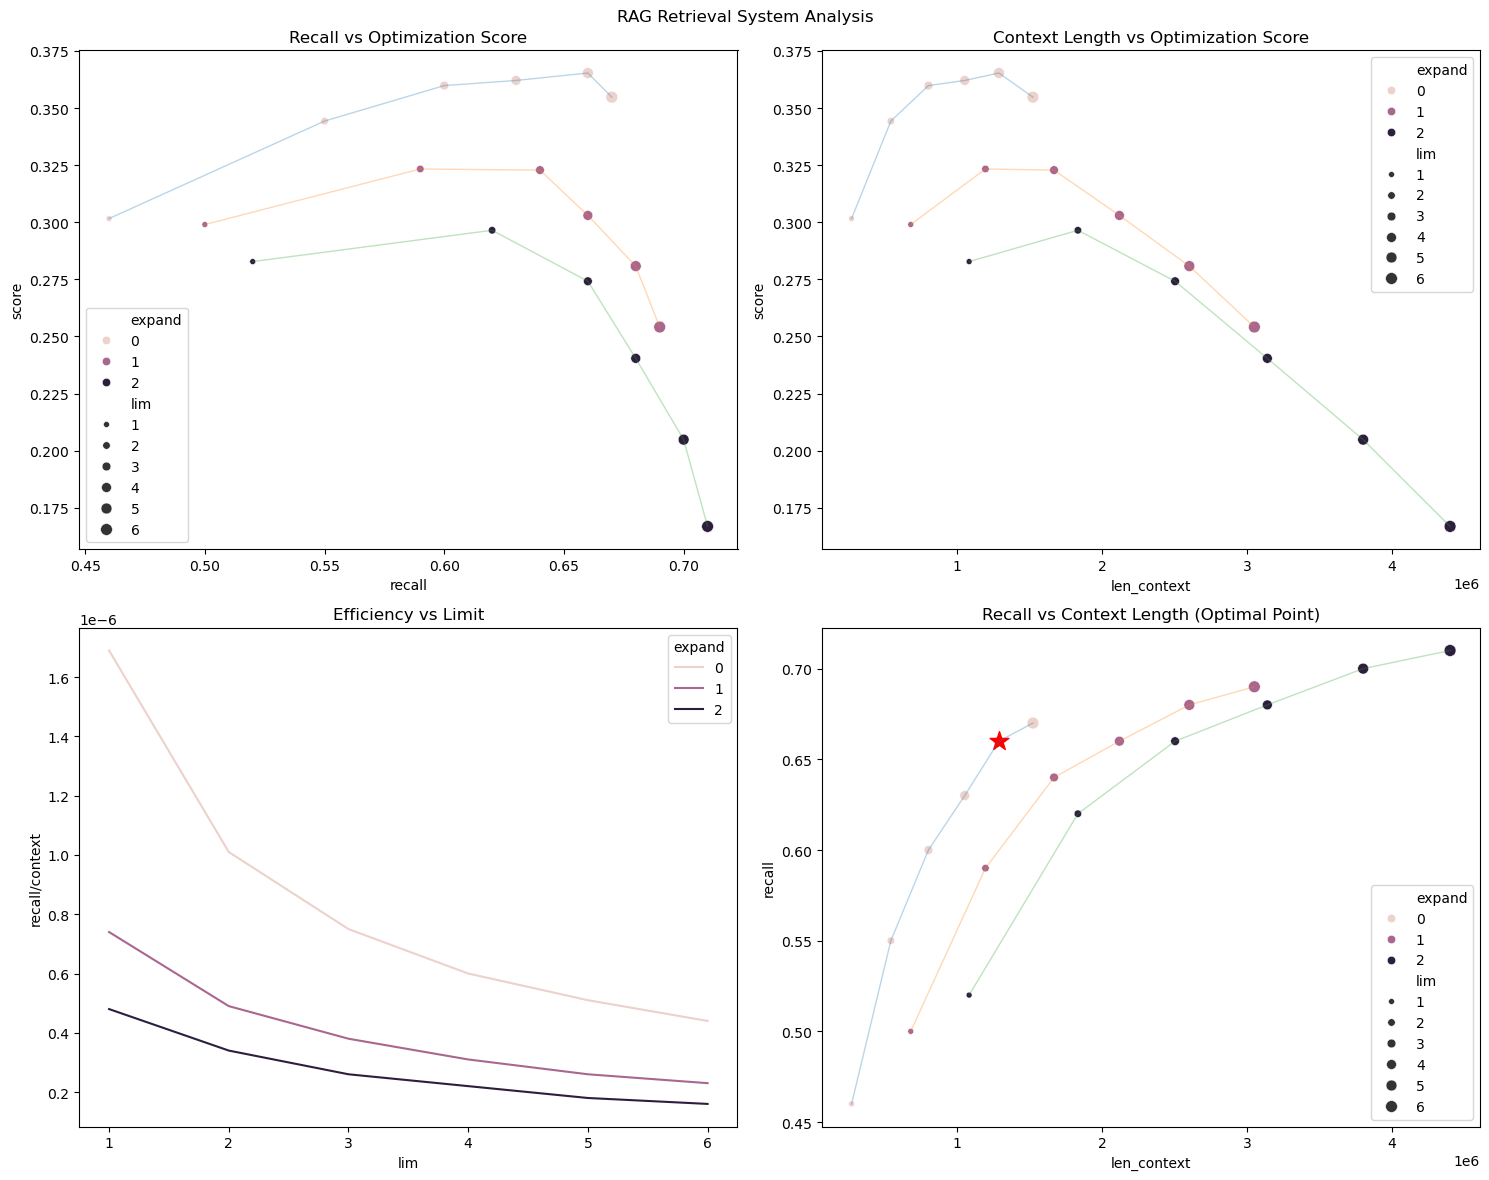

In [64]:


result, margins, fig = main(df_summary)

print(f"Optimal configuration:")
print(f"Expand: {result.expand}")
print(f"Limit: {result.limit}")
print(f"Recall: {result.recall:.3f}")
print(f"Context Length: {result.context_length:,}")
print(f"Score: {result.score:.3f}")

print("\nMarginal benefits when increasing limit:")
print(margins)

plt.show()